In [1]:
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pylab as plt
import matplotlib

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
reshape_dims = [IMG_HEIGHT,IMG_WIDTH]

CLASS_NAMES = ['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']

In [2]:
def read_and_decode(filename, reshape_dims):
  # 1.Read the file
  img = tf.io.read_file(filename)

  # 2.Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

  # 3.Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  # 4.Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  #to find the only True label
  return img, label

#plot Training metrics
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [3]:
#define a function of initializing model
def train_and_evaluate(
        batch_size = 32,
        learning_rate = 0.001,
        l1 = 0, l2 = 0,
        num_hidden = 128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset('/Users/zhuzhirui/.keras/datasets/flower_photos/train_set.csv')
                   .map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset("/Users/zhuzhirui/.keras/datasets/flower_photos/eval_set.csv")
                  .map(decode_csv)).batch(batch_size)

  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    tf.keras.layers.Dense(num_hidden,
                          kernel_regularizer=regularizer,
                          activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(len(CLASS_NAMES),
                          kernel_regularizer=regularizer,
                          activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Epoch 1/10
104/104 [==============================] - 9s 84ms/step - loss: 1.9593 - accuracy: 0.3314 - val_loss: 1.7163 - val_accuracy: 0.3496
Epoch 2/10
104/104 [==============================] - 9s 84ms/step - loss: 1.5643 - accuracy: 0.4023 - val_loss: 1.6338 - val_accuracy: 0.3930
Epoch 3/10
104/104 [==============================] - 9s 82ms/step - loss: 1.5016 - accuracy: 0.4362 - val_loss: 1.6694 - val_accuracy: 0.3902
Epoch 4/10
104/104 [==============================] - 9s 84ms/step - loss: 1.4296 - accuracy: 0.4620 - val_loss: 1.6553 - val_accuracy: 0.3604
Epoch 5/10
104/104 [==============================] - 9s 84ms/step - loss: 1.3196 - accuracy: 0.4944 - val_loss: 1.5807 - val_accuracy: 0.3767
Epoch 6/10
104/104 [==============================] - 10s 92ms/step - loss: 1.2592 - accuracy: 0.5195 - val_loss: 1.6055 - val_accuracy: 0.3848
Epoch 7/10
104/104 [==============================] - 9s 86ms/step - loss: 1.2294 - accuracy: 0.5341 - val_loss: 1.7018 - val_accuracy: 0.376

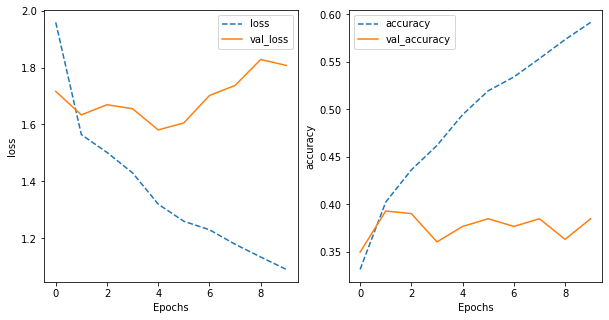

In [4]:
model = train_and_evaluate(batch_size=32, learning_rate=0.0001, l1=0, l2=0, num_hidden=128)

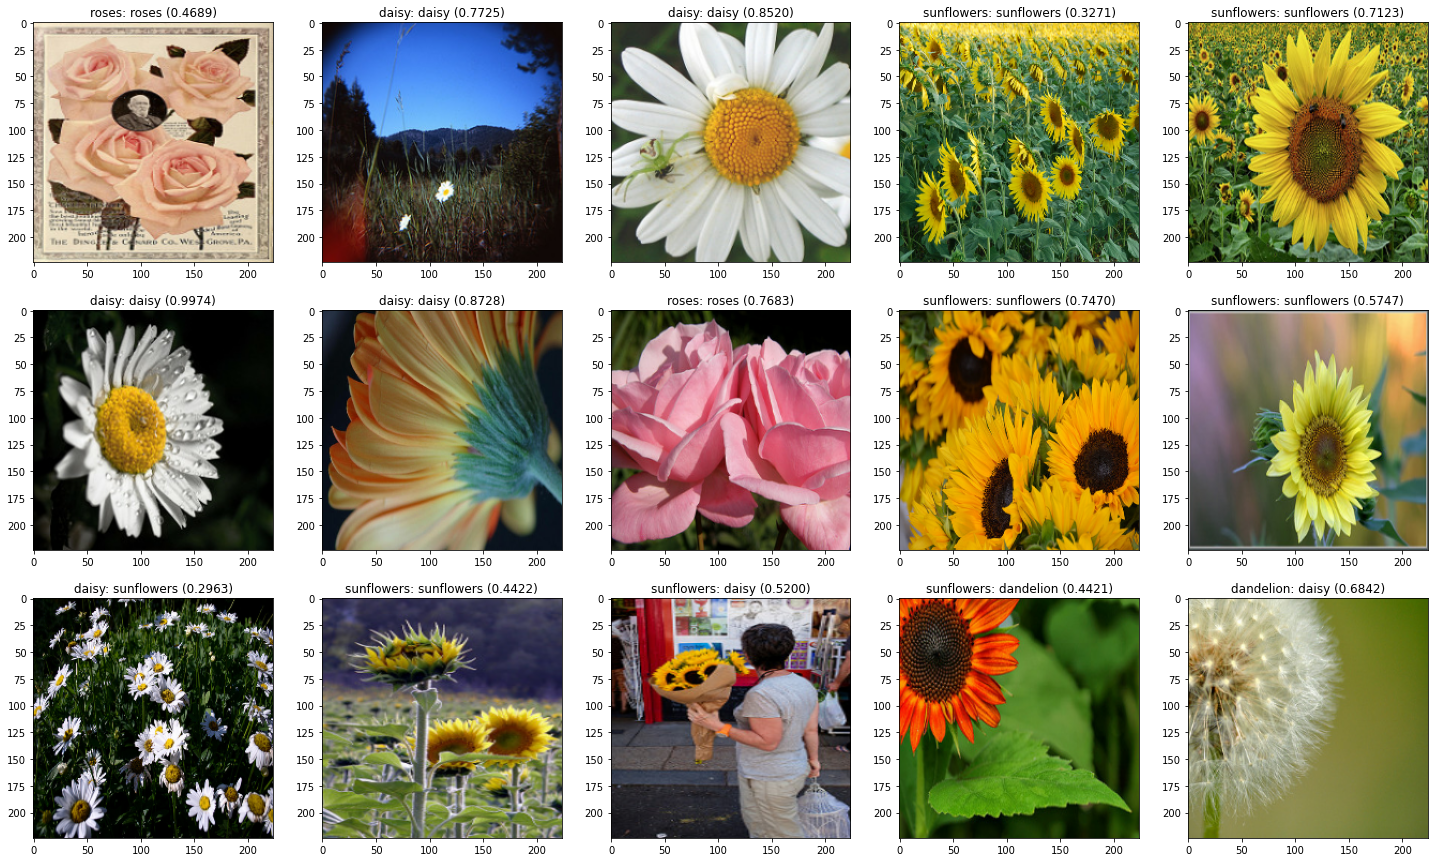

In [5]:
#Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).map(decode_csv))

  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

plot_predictions("/Users/zhuzhirui/.keras/datasets/flower_photos/eval_set.csv")

Epoch 1/10
104/104 [==============================] - 17s 157ms/step - loss: 3.1462 - accuracy: 0.3369 - val_loss: 1.8106 - val_accuracy: 0.3821
Epoch 2/10
104/104 [==============================] - 16s 153ms/step - loss: 1.4718 - accuracy: 0.4405 - val_loss: 1.8002 - val_accuracy: 0.3984
Epoch 3/10
104/104 [==============================] - 16s 153ms/step - loss: 1.4224 - accuracy: 0.4523 - val_loss: 1.7399 - val_accuracy: 0.4201
Epoch 4/10
104/104 [==============================] - 16s 153ms/step - loss: 1.3058 - accuracy: 0.4986 - val_loss: 1.7574 - val_accuracy: 0.4173
Epoch 5/10
104/104 [==============================] - 16s 155ms/step - loss: 1.2991 - accuracy: 0.5041 - val_loss: 1.9177 - val_accuracy: 0.3740
Epoch 6/10
104/104 [==============================] - 17s 162ms/step - loss: 1.2160 - accuracy: 0.5389 - val_loss: 2.0493 - val_accuracy: 0.3821
Epoch 7/10
104/104 [==============================] - 16s 153ms/step - loss: 1.1948 - accuracy: 0.5541 - val_loss: 2.1614 - val_ac

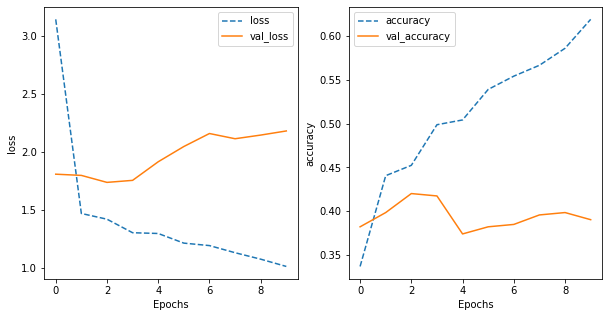

In [6]:
model = train_and_evaluate(batch_size=32, learning_rate=0.0001, l1=0, l2=0, num_hidden=256)

Epoch 1/10
104/104 [==============================] - 17s 153ms/step - loss: 2.4095 - accuracy: 0.3644 - val_loss: 1.7144 - val_accuracy: 0.3957
Epoch 2/10
104/104 [==============================] - 15s 145ms/step - loss: 1.7185 - accuracy: 0.4384 - val_loss: 1.6688 - val_accuracy: 0.4282
Epoch 3/10
104/104 [==============================] - 15s 144ms/step - loss: 1.5260 - accuracy: 0.4844 - val_loss: 1.8015 - val_accuracy: 0.4173
Epoch 4/10
104/104 [==============================] - 15s 142ms/step - loss: 1.4610 - accuracy: 0.5126 - val_loss: 1.7786 - val_accuracy: 0.4011
Epoch 5/10
104/104 [==============================] - 15s 141ms/step - loss: 1.3673 - accuracy: 0.5438 - val_loss: 1.8326 - val_accuracy: 0.4011
Epoch 6/10
104/104 [==============================] - 15s 141ms/step - loss: 1.2878 - accuracy: 0.5689 - val_loss: 1.8987 - val_accuracy: 0.4011
Epoch 7/10
104/104 [==============================] - 15s 140ms/step - loss: 1.2813 - accuracy: 0.5859 - val_loss: 1.8510 - val_ac

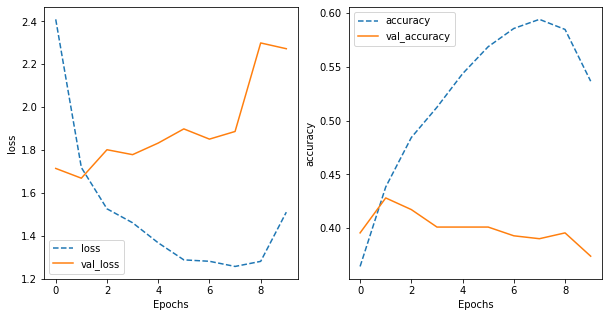

In [7]:
model = train_and_evaluate(batch_size=32, learning_rate=0.0001, l1=0, l2=0.001, num_hidden=128)

In [8]:
#define a function of initializing model
def train_and_evaluate(
        batch_size = 32,
        learning_rate = 0.001,
        l1 = 0, l2 = 0,
        num_hidden = 128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset('/Users/zhuzhirui/.keras/datasets/flower_photos/train_set.csv')
                   .map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset("/Users/zhuzhirui/.keras/datasets/flower_photos/eval_set.csv")
                  .map(decode_csv)).batch(batch_size)

  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    tf.keras.layers.Dense(num_hidden,
                          kernel_regularizer=regularizer,
                          activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(len(CLASS_NAMES),
                          kernel_regularizer=regularizer,
                          activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10, 
                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
  training_plot(['loss', 'accuracy'], history)
  return model

Epoch 1/10
104/104 [==============================] - 16s 148ms/step - loss: 2.5030 - accuracy: 0.3650 - val_loss: 2.0608 - val_accuracy: 0.3984
Epoch 2/10
104/104 [==============================] - 15s 144ms/step - loss: 1.6593 - accuracy: 0.4408 - val_loss: 2.2183 - val_accuracy: 0.3794
Epoch 3/10
104/104 [==============================] - 15s 143ms/step - loss: 1.6371 - accuracy: 0.4550 - val_loss: 1.8150 - val_accuracy: 0.4282
Epoch 4/10
104/104 [==============================] - 15s 143ms/step - loss: 1.5664 - accuracy: 0.4889 - val_loss: 1.6271 - val_accuracy: 0.3930
Epoch 5/10
104/104 [==============================] - 15s 143ms/step - loss: 1.4216 - accuracy: 0.5280 - val_loss: 1.6235 - val_accuracy: 0.4173
Epoch 6/10
104/104 [==============================] - 15s 142ms/step - loss: 1.3322 - accuracy: 0.5574 - val_loss: 1.6692 - val_accuracy: 0.4255
Epoch 7/10
104/104 [==============================] - 15s 148ms/step - loss: 1.2759 - accuracy: 0.5759 - val_loss: 1.7830 - val_ac

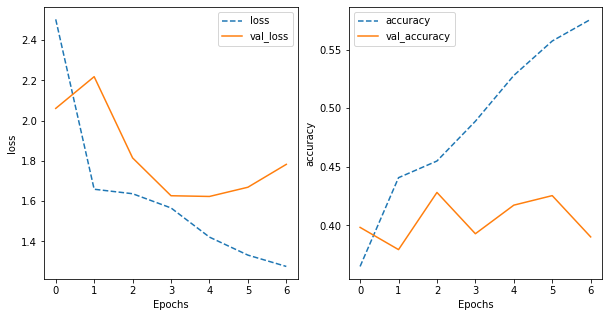

In [9]:
model = train_and_evaluate(batch_size=32, learning_rate=0.0001, l1=0, l2=0.001, num_hidden=128)